<a href="https://colab.research.google.com/github/Potdooshami/SVO_gapmap/blob/main/svoVisualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📋 TODO
- [ ] from pixel unit to nano unit
- [ ] 모델 학습 완료
- [ ] 결과 그래프 개선
여기서 커밋하면?

# Rawdata
## Rawdata header
| Variable | Description | Dimensions | Notes |
|---|---|---|---|
| G | STS (Scanning Tunneling Spectroscopy) | (ix, iy, iE, iH) |  |
| Z | Topography | (ix, iy, iH) |  |
| stat | Result of G process | (ix, iy, iH, iS) | iS = {gap, peakH, subgapSate} |
| V | Bias |  |  |
| nano | nanometer |  | Unit |

In [153]:
# @title Load rawdata
# @markdown Do not touch this!!
from google.colab import drive

import h5py
import numpy as np
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/svo/fromMatlab/svo.h5'  # Replace with your actual file path
fn = '/content/drive/MyDrive/svo/fromMatlab/bg.h5' # background related
'''
with h5py.File(file_path, 'r') as f:
    for key in f.keys():
        data = f[key][:]  # Load the dataset
        rank = data.ndim  # Get the rank
        transpose_order = tuple(range(rank - 1, -1, -1))  # Create transpose order
        globals()[key] = np.transpose(data, transpose_order)  # Transpose and assign
'''
def loadh5(fn):
  with h5py.File(fn, 'r') as f:
    for key in f.keys():
        data = f[key][:]  # Load the dataset
        rank = data.ndim  # Get the rank
        transpose_order = tuple(range(rank - 1, -1, -1))  # Create transpose order
        globals()[key] = np.transpose(data, transpose_order)  # Transpose and assign
loadh5(file_path)
loadh5(fn)
# Now you can access the datasets using their names (e.g., G, sp, V) with transposed indices

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data reshape

In [225]:
#combine stat and dt
stat.shape
stat_add =  np.expand_dims(dt[:,:,0:2],axis=3)
stats = np.concatenate((stat,stat_add),axis=3)
stats = np.nan_to_num(stats, nan=0.0)

nano[0]/

array([[270.1171875, 270.1171875]])

#Function space

In [155]:
def xywh_to_xyrec(xywh):
  """Converts an xywh array to an xyrec array.

  Args:
    xywh: A 1x4 NumPy array representing [x, y, width, height].

  Returns:
    A 2x5 NumPy array representing the rectangle's corners:
    [[x1, x2, x3, x4, x1],
     [y1, y2, y3, y4, y1]]
  """
  x, y, w, h = xywh
  xyrec = np.array([[x, x + w, x + w, x, x],
                    [y, y, y + h, y + h, y]])
  return xyrec

#Visualization

## Choose window for crop

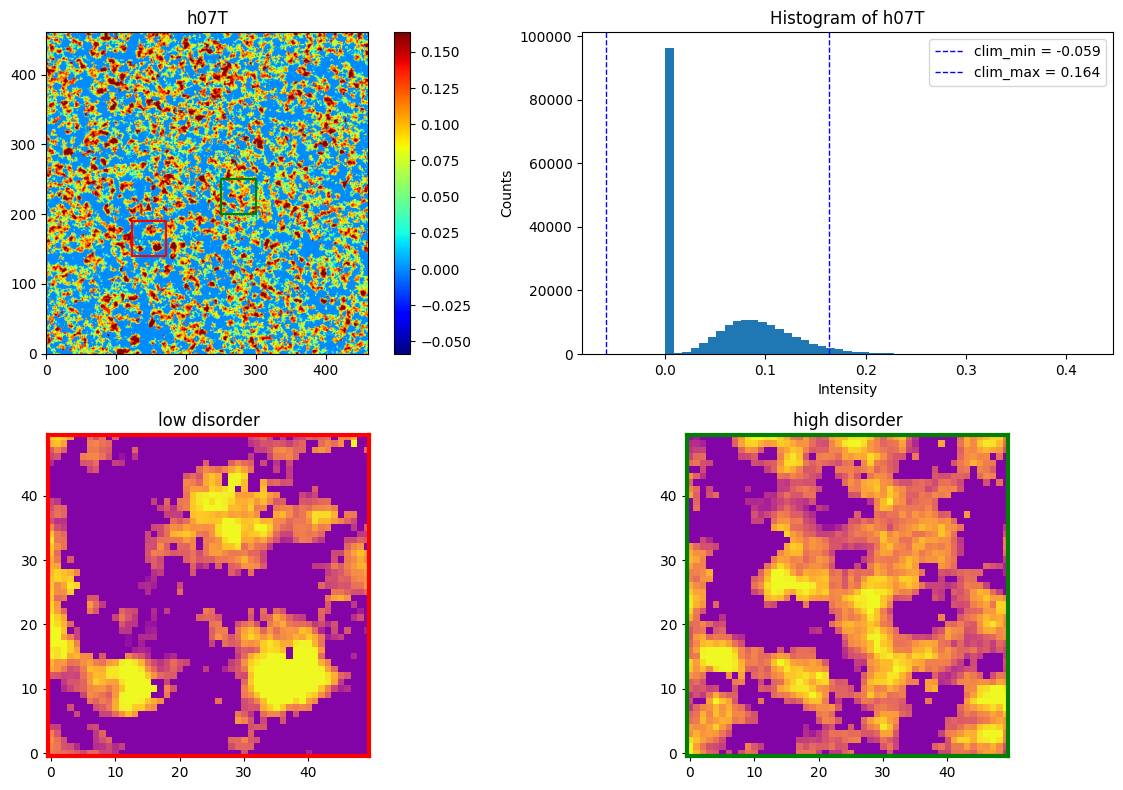

In [156]:
# @title drawing
Hfield = "h07T" # @param ["0T","7T","h07T"]

# @markdown ---
floor = 2 # @param {type:"number"}
ceil  = 2 # @param {type:"number"}
# @markdown ---
xy1 = [122, 140] # @param
xy2 = [250, 200] # @param
#xy1 = [100, 0]
#xy2 = [0, 100]
xy =[xy1,xy2]
# @markdown ---
L = 50 # @param
clrslc = ["r","g"]
nmslc = ["low disorder","high disorder"]
iH = 0
if Hfield == "7T":
  iH = 1
elif Hfield == "h07T":
  iH = 2

# prompt: (left pannel)
# imshow Z[:,:,1] colormap gray, colorbar,
# clim +-2\sigma
# (right pannel)
# corresponding histogram
# insert clim info of left as a xline
xywh = np.array([xy1+[L, L], xy2+[L, L]])


import matplotlib.pyplot as plt

# Assuming Z is already loaded and available in the current scope

# Calculate the mean and standard deviation of Z[:,:,1]
if iH == 2:
  pln_dd = dt[:,:,1]
else:
  pln_dd = stat[:,:,iH,2]

pln_dd = np.nan_to_num(pln_dd, nan=0.0)

mean_Z = np.mean(pln_dd)
std_Z = np.std(pln_dd)

# Set the color limits
clim_min = mean_Z - floor * std_Z
clim_max = mean_Z + ceil * std_Z


# Create the figure and axes
fig, axs = plt.subplots(2, 2, figsize=(12, 8))


# Left panel: imshow of Z[:,:,1]

im = axs[0,0].imshow(pln_dd.T,origin='lower', cmap='jet', clim=(clim_min, clim_max))
axs[0,0].imshow(pln_dd.T,origin='lower', cmap='jet', clim=(clim_min, clim_max))
fig.colorbar(im, ax=axs[0,0])
axs[0,0].set_title(Hfield)
for isl in range(2):
  xyrec = xywh_to_xyrec(xywh[isl])
  axs[0,0].plot(xyrec[0], xyrec[1], clrslc[isl])
#axs[0,0].invert_yaxis()


# Right panel: Histogram of Z[:,:,1]
axs[0,1].hist(pln_dd.flatten(), bins=50)
axs[0,1].set_title('Histogram of ' + Hfield)
axs[0,1].set_xlabel('Intensity')
axs[0,1].set_ylabel('Counts')

# Add clim info as vertical lines to the histogram
axs[0,1].axvline(clim_min, color='b', linestyle='dashed', linewidth=1, label=f'clim_min = {clim_min:.3f}')
axs[0,1].axvline(clim_max, color='b', linestyle='dashed', linewidth=1, label=f'clim_max = {clim_max:.3f}')
axs[0,1].legend()
xrng = [None,None]
yrng = [None,None]
for j in range(2):
    xrng[j] = slice(xywh[j,0],xywh[j,0]+xywh[j,2])
    yrng[j] = slice(xywh[j,1],xywh[j,1]+xywh[j,3])
    pln_dd_crop = pln_dd[xrng[j],yrng[j]]
    axs[1,j].imshow(pln_dd_crop.T,origin='lower',cmap='plasma', clim=(clim_min, clim_max))
    #axs[1,j].invert_yaxis()
    axs[1,j].set_title(nmslc[j])
    for spine in axs[1,j].spines.values():
      spine.set_edgecolor(clrslc[j])
      spine.set_linewidth(3)

plt.tight_layout()
plt.show()

(0.0, 200.0)

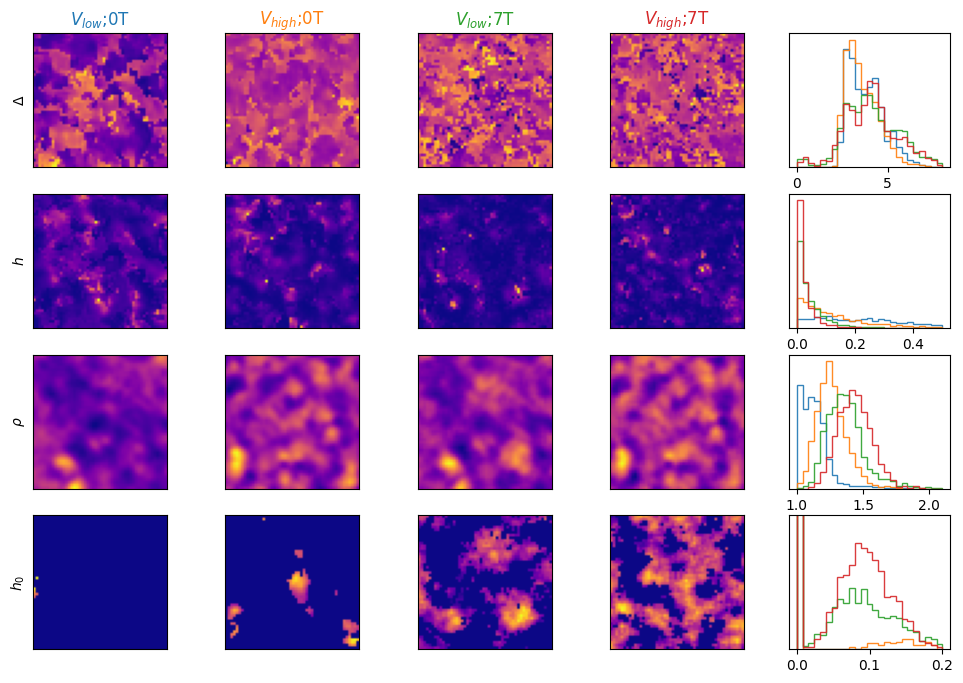

In [224]:
stat
msb,nsb=4,5
fig,axs = plt.subplots(msb,nsb,figsize=(12, 8))
isbs,jsbs = range(msb),range(nsb)
iVs,iHs = [0,1,0,1],[0,0,1,1]
yns =  [r'$\Delta$',r'$h$',r'$\rho$',r'$h_0$']
nSs = yns
nVs = ['$V_{low}$','$V_{high}$']
nHs = ['0T','7T']
mins = [0, 0, 1,0]
maxs = [8,.5,2.1,0.2]
tcs = plt.rcParams['axes.prop_cycle'].by_key()['color']
for isb,iS,yn in zip(isbs,isbs,yns):
  for jsb,iV,iH,tc in zip(jsbs,iVs,iHs,tcs):
    nV,nH = nVs[iV],nHs[iH]
    tn = nV+';'+nH
    pln = stats[xrng[iV],yrng[iV],iH,iS]
    axs[isb,jsb].imshow(pln.T, cmap='plasma')
    axs[isb, jsb].set(xticks=[], yticks=[])
    axs[isb, jsb].invert_yaxis()
    if jsb ==0:
      axs[isb,jsb].set_ylabel(yn)
    if isb ==0:
      axs[isb,jsb].set_title(tn,color = tc)
    #axs[isb,4].hist(pln.flatten(),alpha= .9,bins=25,histtype='step')
    axs[isb,4].hist(pln.flatten(),alpha= .9,bins=25,histtype='step',range=(mins[isb],maxs[isb]))
    axs[isb,4].set(yticks=[])
axs[3,4].set_ylim([0,200])

Joint Histogram

Text(0.5, 1.02, 'Cross-correlations for high disorder')

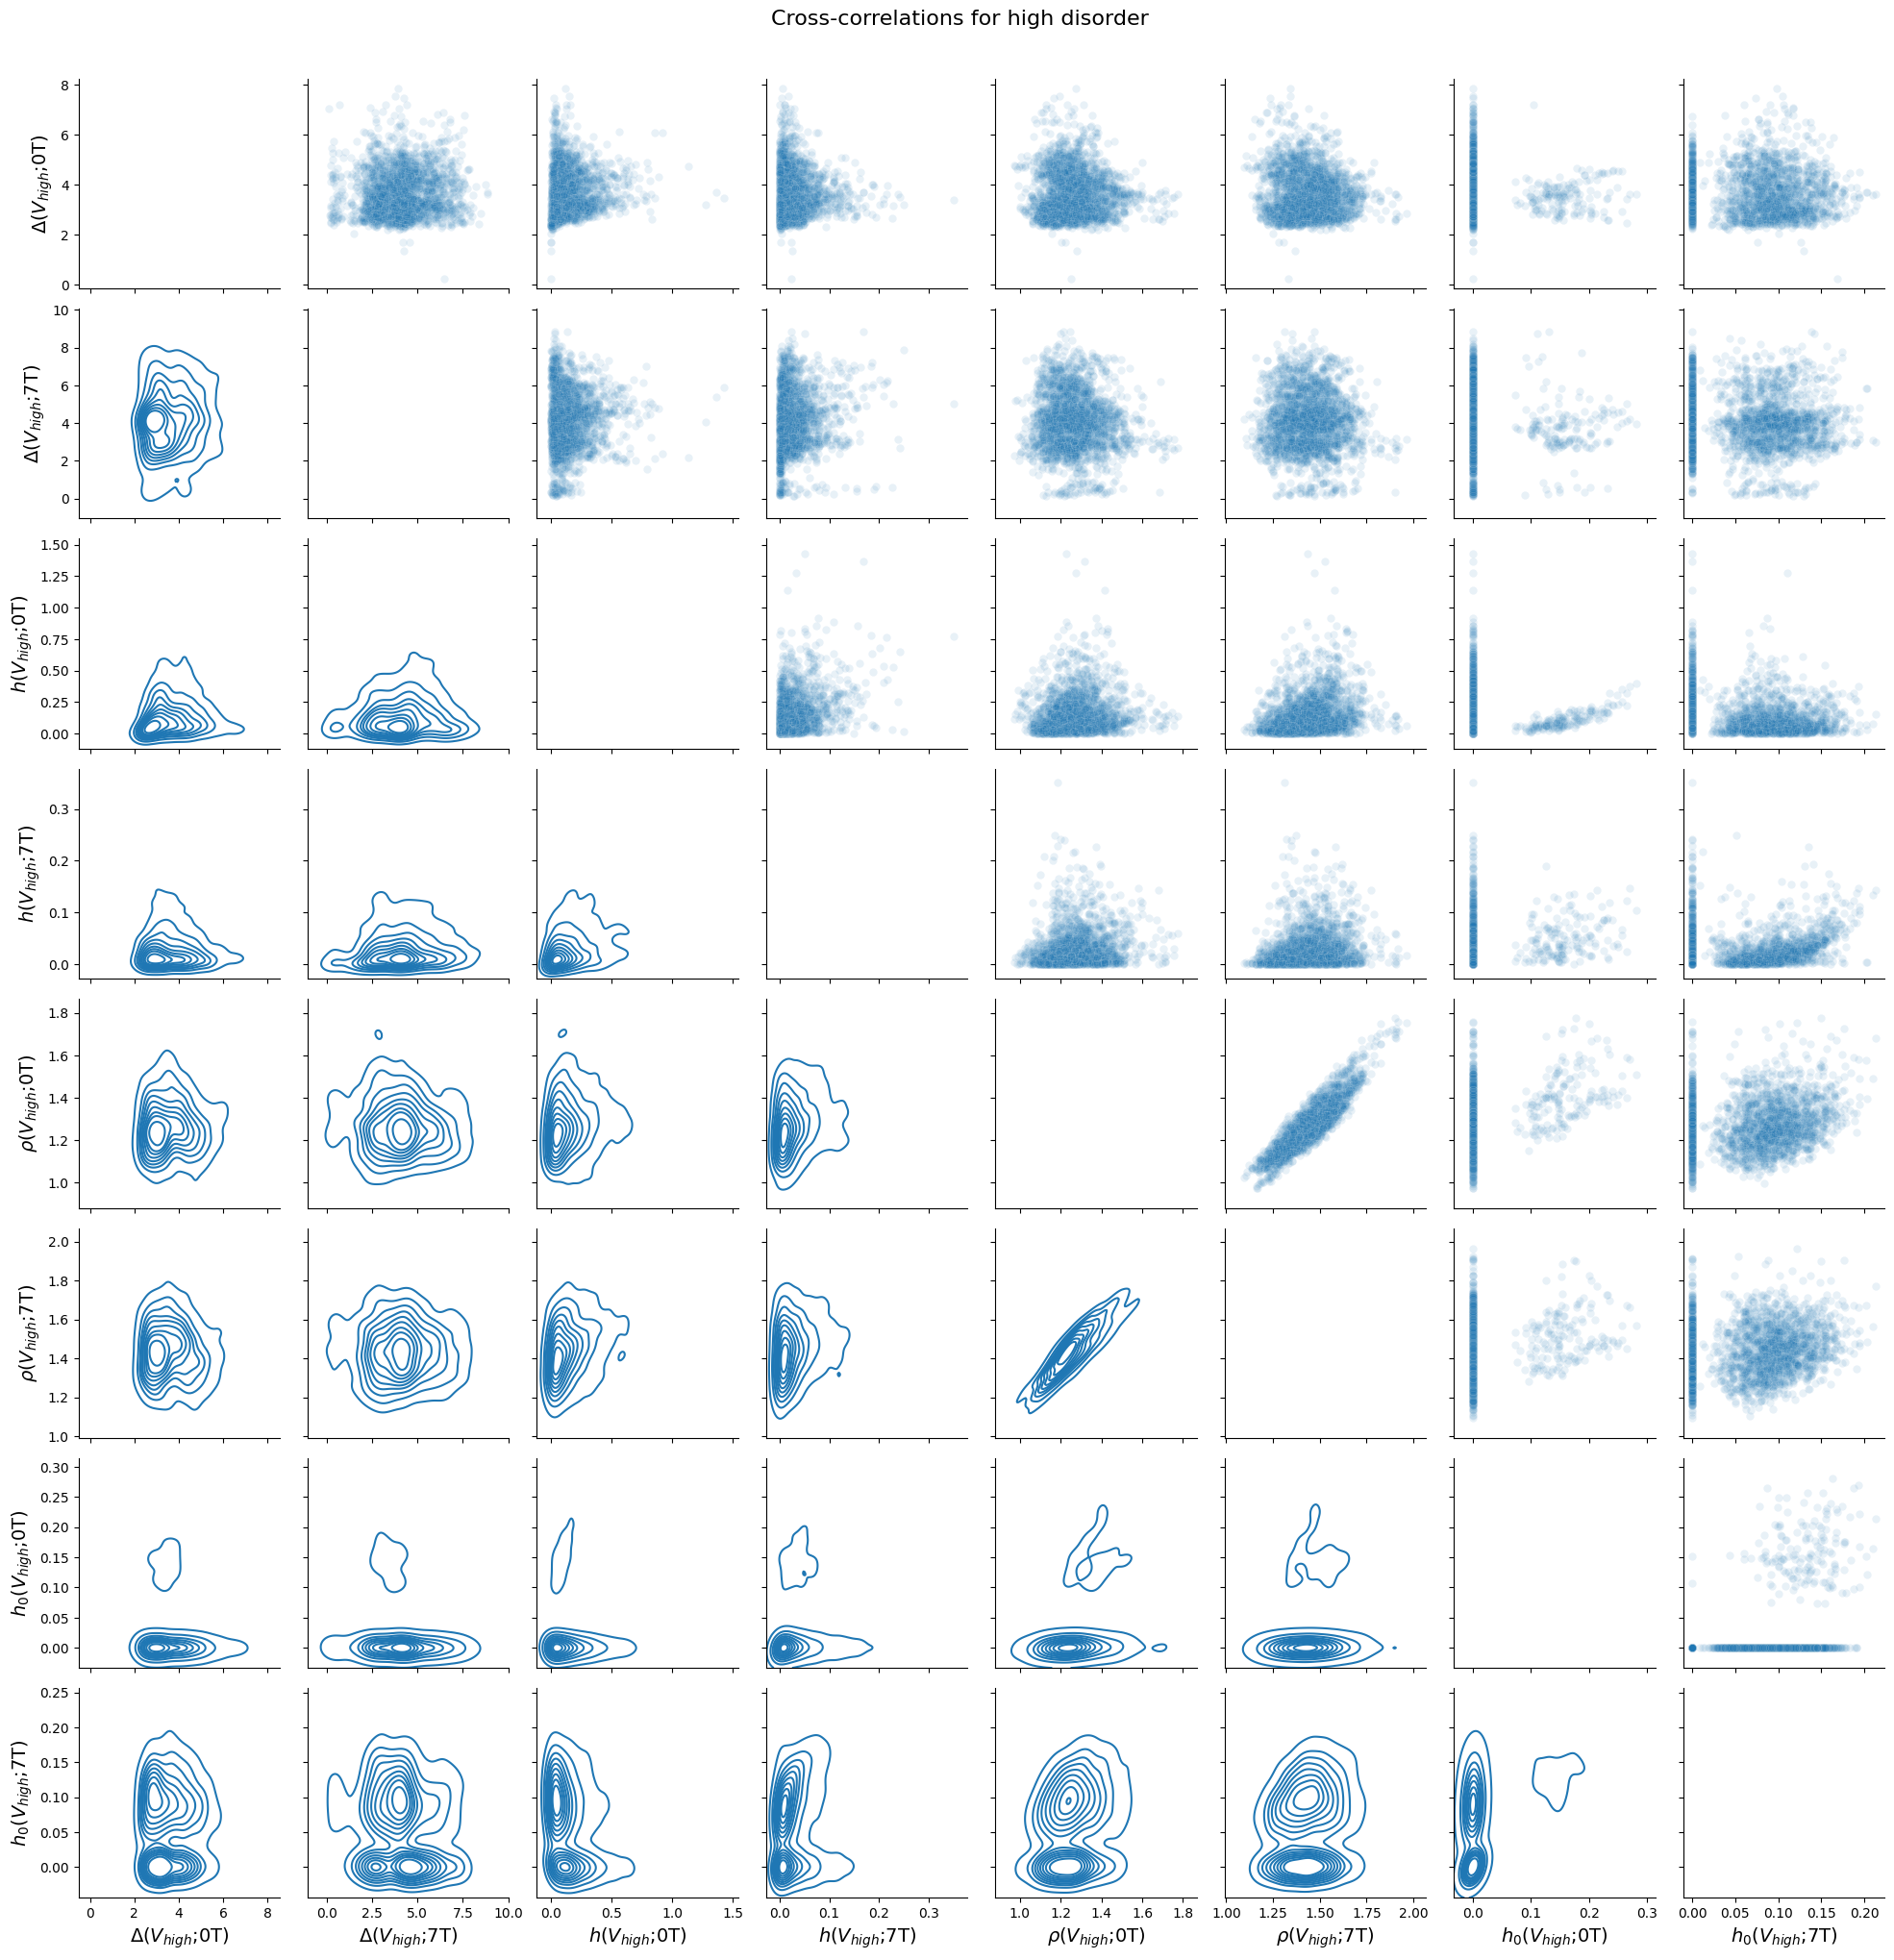

In [217]:
disorder = "high" # @param ["low","high"]
# @markdown ---
disorder_map = {"low": 0, "high": 1}
iV = disorder_map[disorder]
import pandas as pd
import seaborn as sns
arr =  np.zeros((L*L,16))
idx = 0
cols = []
# The yns variable is not defined in this scope, so we need to define it here.
yns =  [r'$\Delta$',r'$h$',r'$\rho$',r'$h_0$'] # Define yns within the loop
for iVv in range(2):
  for iS in range(4):
    for iH in range(2):
      nV,nH = nVs[iVv],nHs[iH]
      # Access yn using the current value of iS to get the correct prefix
      cols.append(yns[iS] +'('+ nV+';'+nH + ')')
      pln = stats[xrng[iVv],yrng[iVv],iH,iS]
      arr[:,idx] = pln.flatten()
      idx = idx + 1

dff = pd.DataFrame(arr,columns=cols)
slc = np.array(range(8))
if iV == 0:
  print('s')

elif iV == 1:
  slc = slc + 8
gg = sns.PairGrid(dff.iloc[:,slc])
#gg.map_diag(sns.scatterplot,alpha =.1)
#gg.map_offdiag(sns.scatterplot,alpha =.1)
gg.map_upper(sns.scatterplot,alpha =.1)
gg.map_lower(sns.kdeplot)
label_fontsize = 14
for ax in gg.axes[:, 0]:  # Iterate over the first column of axes (y-axis labels)
    ax.set_ylabel(ax.get_ylabel(), fontsize=label_fontsize)
for ax in gg.axes[-1, :]:  # Iterate over the last row of axes (x-axis labels)
    ax.set_xlabel(ax.get_xlabel(), fontsize=label_fontsize)
super_title = "Cross-correlations for " + disorder + " disorder"
plt.suptitle(super_title, y=1.02, fontsize=16)  # Adjust 'y' for vertical positioning


Text(40.525, 0.5, 'Axes(0.0716222,0.764781;0.195791x0.212775)')